In [23]:
from spice.models import IcosphereModel
from spice.models.mesh_transform import add_rotation, evaluate_rotation
from spice.models.spots import add_spots
from spice.plots import plot_3D
from spice.spectrum import simulate_spectrum, luminosity, filter_responses
from spice.spectrum.spectrum import simulate_total_flux
import astropy.units as u
from speclite import filters
import jax.numpy as jnp
import numpy as np
from transformer_payne import TransformerPayne, Blackbody
import matplotlib.pyplot as plt

from jax import config
config.update('jax_platform_name', 'cpu')
config.update("jax_enable_x64", True)

Use blackbody intensity for tests:

In [24]:
bb = Blackbody()
tp = TransformerPayne.download()

An easy, solar-like model.

In [25]:
m = IcosphereModel.construct(1000, u.solRad.to(u.cm), 1., 1., bb.solar_parameters)
# tp_m = IcosphereModel.construct(1000, u.solRad.to(u.cm), 1., 1., tp.solar_parameters)

In [53]:
vws = jnp.linspace(1000., 40000., 1000)

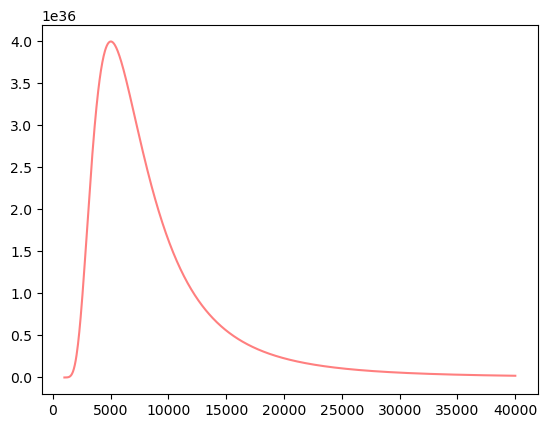

In [54]:
i_bb = simulate_spectrum(bb.intensity, m, jnp.log10(vws), chunk_size=1000)
# i_tp = simulate_spectrum(tp.intensity, tp_m, jnp.log10(vws))
plt.plot(vws, i_bb[:, 1], color='red', alpha=0.5)
#plt.plot(vws, i_tp[:, 1], color='royalblue', alpha=0.5)

In [55]:
from jax.scipy.integrate import trapezoid
from astropy import constants as c

sc = trapezoid(x = vws*1e-8, y = i_bb[:, 0])/(u.AU.to(u.cm)**2)
sc*(u.erg/(u.s*u.cm**2)).to(u.W/u.m**2)

Array(1346.73756476, dtype=float64)

In [56]:
i_bb = simulate_spectrum(bb.intensity, m, jnp.log10(vws), chunk_size=256)
sc = trapezoid(x = vws*1e-8, y = i_bb[:, 0])/(u.AU.to(u.cm)**2)
sc*(u.erg/u.s/u.cm**2).to(u.W/u.m**2)    

Array(1346.73756476, dtype=float64)

In [57]:
from jax.scipy.integrate import trapezoid
from spice.spectrum.spectrum import luminosity

In [58]:
l = luminosity(bb.flux, m, jnp.log10(vws))
l

Array(3.80387336e+33, dtype=float64)

In [59]:
-2.5*jnp.log10(l*(u.erg/u.s).to(u.W))+71.1974

Array(4.74683487, dtype=float64)

In [60]:
integrated_i = trapezoid(x=vws, y=i_bb[:, 0])
integrated_i

Array(3.01393442e+40, dtype=float64)

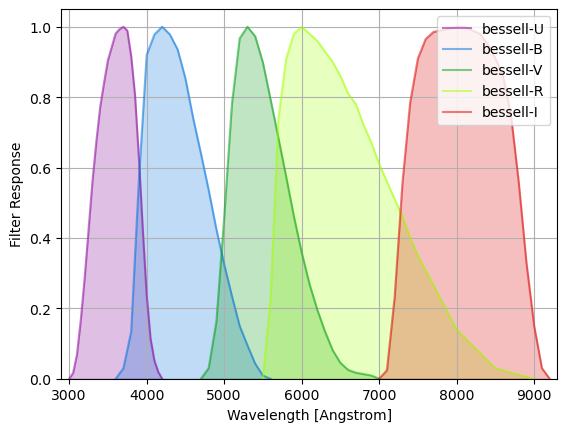

In [61]:
bessell = filters.load_filters('bessell-*')
filters.plot_filters(bessell, wavelength_limits=(2900, 9300))

In [62]:
bessell[4].__dict__

{'_wavelength': array([7000., 7100., 7200., 7300., 7400., 7500., 7600., 7700., 7800.,
        7900., 8000., 8100., 8200., 8300., 8400., 8500., 8600., 8700.,
        8800., 8900., 9000., 9100., 9200.]),
 'band_shift': None,
 '_response': array([0.   , 0.024, 0.232, 0.555, 0.785, 0.91 , 0.965, 0.985, 0.99 ,
        0.995, 1.   , 1.   , 0.99 , 0.98 , 0.95 , 0.91 , 0.86 , 0.75 ,
        0.56 , 0.33 , 0.15 , 0.03 , 0.   ]),
 'meta': {'url': 'http://dx.doi.org/10.1086/132749',
  'band_name': 'I',
  'airmass': 0.0,
  'description': 'Reference definition of the Johnson/Cousins "standard" I filter based on: Bessell, M. S., "UBVRI passbands," PASP, vol. 102, Oct. 1990, p. 1181-1199. Note that these do not represent the response of any actual instrument. Response values are normalized to have a maximum of one.',
  'group_name': 'bessell'},
 'interpolator': <scipy.interpolate._interpolate.interp1d at 0x16d30a8f0>,
 'effective_wavelength': <Quantity 8086.39904467 Angstrom>,
 'ab_zeropoint': <Quanti

(0.0, 15000.0)

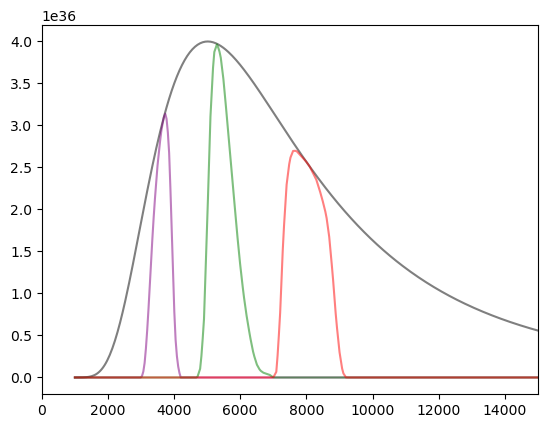

In [63]:
u_passband = filter_responses(vws, bessell[0]._wavelength, bessell[0]._response)
v_passband = filter_responses(vws, bessell[2]._wavelength, bessell[2]._response)
i_passband = filter_responses(vws, bessell[4]._wavelength, bessell[4]._response)
plt.plot(vws, i_bb[:, 0], color='black', alpha=0.5)
plt.plot(vws, i_bb[:, 0]*u_passband, color='purple', alpha=0.5, label='U')
plt.plot(vws, i_bb[:, 0]*v_passband, color='green', alpha=0.5, label='R')
plt.plot(vws, i_bb[:, 0]*i_passband, color='red', alpha=0.5, label='I')
plt.gca().set_xlim(0, 15000)

In [64]:
from astropy import constants as c

vws_hz = c.c.to(u.cm/u.s).value*1e8/vws
fv = (i_bb*1e-4*3.34*jnp.repeat(vws[:, jnp.newaxis], 2, axis=1)**2)*(u.Jy).to(u.erg/u.s/u.cm**2/u.Hz)
fv_JY = (i_bb*1e-4*3.34*jnp.repeat(vws[:, jnp.newaxis], 2, axis=1)**2)*(u.Jy)

vws_mask = jnp.argsort(vws_hz)
fv = fv[vws_mask]
vws_hz = jnp.sort(vws_hz)

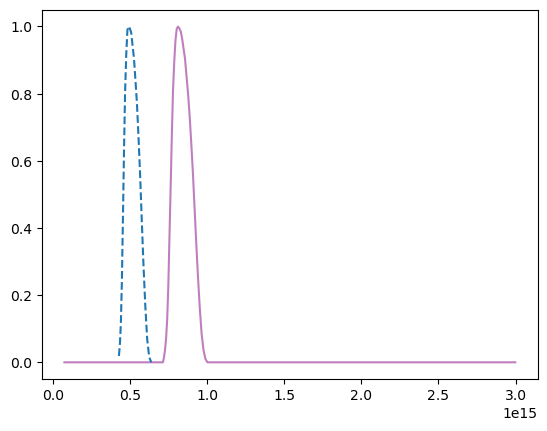

In [77]:
bessel_hz = c.c.to(u.cm/u.s).value*1e8/(bessell[0]._wavelength)
sort_mask = jnp.argsort(bessel_hz)
u_passband = filter_responses(jnp.sort(vws_hz), bessel_hz[sort_mask],  bessell[0]._response[sort_mask])
bessel_hz = c.c.to(u.cm/u.s).value*1e8/(bessell[2]._wavelength)
sort_mask = jnp.argsort(bessel_hz)
v_passband = filter_responses(jnp.sort(vws_hz), bessel_hz[sort_mask],  bessell[2]._response[sort_mask])
plt.plot(vws_hz, u_passband, color='purple', alpha=0.5, label='U')
plt.plot(bessel_hz[sort_mask], bessell[0]._response[sort_mask], linestyle='--', label='U')

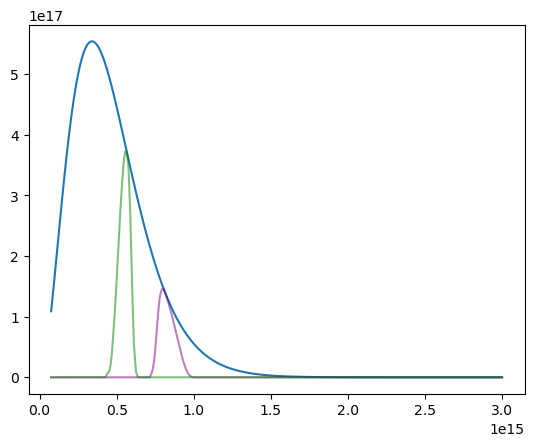

In [78]:
plt.plot(vws_hz, fv[:, 0])
plt.plot(vws_hz, fv[:, 0]*u_passband, color='purple', alpha=0.5, label='U')
plt.plot(vws_hz, fv[:, 0]*v_passband, color='green', alpha=0.5, label='V')

In [79]:
(c.h).to(u.erg*u.s)

<Quantity 6.62607015e-27 erg s>

In [80]:
trapezoid(x=vws_hz, y=fv[:, 0])

Array(3.01801386e+32, dtype=float64)

In [81]:
-2.5*jnp.log10(trapezoid(x=vws_hz, y=fv[:, 0])*(u.erg/u.s).to(u.W))

Array(-63.69930308, dtype=float64)

In [82]:
CONST = (3631*u.Jy).to(u.erg/u.s/u.cm**2/u.Hz)
CONST

<Quantity 3.631e-20 erg / (cm2 Hz s)>

In [83]:
trapezoid(x=vws_hz, y=fv[:, 0])

Array(3.01801386e+32, dtype=float64)

In [84]:
-2.5*jnp.log10(trapezoid(x=vws_hz, y=fv[:, 0]*u_passband/(u.AU.to(u.cm)**2)/(c.h.to(u.erg*u.s)*vws_hz))/
               trapezoid(x=vws_hz, y=CONST*u_passband/(c.h.to(u.erg*u.s)*vws_hz)))

Array(-25.49165961, dtype=float64)

In [88]:
-2.5*jnp.log10(trapezoid(x=vws_hz, y=fv[:, 0]*u_passband/(100*u.pc.to(u.cm)**2)/(c.h.to(u.erg*u.s)*vws_hz))/
               trapezoid(x=vws_hz, y=CONST*u_passband/(c.h.to(u.erg*u.s)*vws_hz)))

Array(6.08046605, dtype=float64)

In [85]:
-2.5*jnp.log10(trapezoid(x=vws_hz, y=fv[:, 0]*v_passband/(u.AU.to(u.cm)**2)/(c.h.to(u.erg*u.s)*vws_hz))/
               trapezoid(x=vws_hz, y=CONST*v_passband/(c.h.to(u.erg*u.s)*vws_hz)))

Array(-26.70574462, dtype=float64)

In [89]:
-2.5*jnp.log10(trapezoid(x=vws_hz, y=fv[:, 0]*v_passband/(100*u.pc.to(u.cm)**2)/(c.h.to(u.erg*u.s)*vws_hz))/
               trapezoid(x=vws_hz, y=CONST*v_passband/(c.h.to(u.erg*u.s)*vws_hz)))

Array(4.86638105, dtype=float64)

In [22]:
from astropy import constants as c

In [23]:
c.c.to(u.cm/u.s).value

29979245800.0

$f=\frac{c}{\lambda}$

$f_\nu\ [\rm{ergs}\ s^{-1} \rm{cm}^{-2} \rm{Hz}^{-1}] = 
\frac{\lambda}{c}^2\cdot 10^8\cdot f_\lambda\ [\rm{ergs}\ s^{-1} \rm{cm}^{-2} \AA^{-1}]$

In [69]:
c.h.to(u.erg*u.s)

<Quantity 6.62607015e-27 erg s>

In [202]:
-2.5*jnp.log10(trapezoid(x=vws_hz, y=fv_JY[:, 0]/3631))

Array(-133.26711698, dtype=float64)

In [70]:
fv = (f_bb*1e4*3.34*jnp.repeat(vws[:, jnp.newaxis], 2, axis=1)**2)*(u.Jy).to(u.erg/u.s/u.cm**2/u.Hz)

In [71]:
vws_hertz = c.c.to(u.cm/u.s).value/(vws[:, jnp.newaxis])

In [35]:
-2.5*jnp.log10(trapezoid(fv/(c.h*)))

TypeError: unsupported operand type(s) for *: 'float' and 'PjitFunction'

In [15]:
# def flux_density_hz(wavelengths: ArrayLike,
#                     flux_density_A: ArrayLike) -> Tuple[ArrayLike, ArrayLike]:
    
#     freqs = C_CENTIMETERS/(wavelengths*1e-8)
#     return freqs, jnp.power(wavelengths, 2)/C_CENTIMETERS*1e8*flux_density_A

In [16]:
# hz, fhz = flux_density_hz(vws, i[:, 0]*i_passband)
# p = luminosity(jnp.repeat(fhz.reshape((-1, 1)), axis=1, repeats=2), jnp.nan_to_num(hz), m)

In [17]:
# -2.5*jnp.log10(p)

In [18]:
# -2.5*jnp.log10(passband_luminosity(i, i_passband, vws, m))+2.5*jnp.log10(2.48*1e-9*1e-7)

In [19]:
# u_luminosity = absolute_bol_luminosity(passband_luminosity(i, u_passband, vws, m))
# v_luminosity = absolute_bol_luminosity(passband_luminosity(i, v_passband, vws, m))
# i_luminosity = absolute_bol_luminosity(passband_luminosity(i, i_passband, vws, m))

In [20]:
# -2.5*jnp.log10(passband_luminosity(i, i_passband, vws, m))

In [21]:
# passband_luminosity(i, i_passband, vws, m)

In [22]:
# passband_luminosity(i, i_passband, vws, m), luminosity(i, vws, m)